In [135]:
# Imports and functions
import numpy as np
import nibabel as nib
from nilearn import plotting, image
from dipy.denoise.nlmeans import nlmeans
from dipy.denoise.noise_estimate import estimate_sigma
from dipy.io.image import load_nifti, save_nifti

def get_cv(img: nib.Nifti1Image, mask: nib.Nifti1Image) -> float:
    """
    Calculates the coefficient of variation (CV) within a specified mask for the image.
    """
    data = img.get_fdata()
    white_matter_voxels = data[mask > 0.9]
    mu = np.mean(white_matter_voxels)
    sigma = np.std(white_matter_voxels)
    cv = sigma / mu
    return cv

def denoise_smoothing(img: nib.Nifti1Image, fwhm: float) -> nib.Nifti1Image:
    """
    Denoises the image using Gaussian smoothing with the specified full-width at half-maximum (FWHM).
    """
    smoothed_img = image.smooth_img(img, fwhm)
    return smoothed_img

def denoise_nlm(img: nib.Nifti1Image) -> nib.Nifti1Image:
    """
    Denoises the image using Non-Local Means (NLM) filtering and returns the denoised image.
    """
    data = img.get_fdata()
    affine = img.affine
    header = img.header
    sigma = estimate_sigma(data)  # Estimate the noise standard deviation from the data.
    denoised_data = nlmeans(data, sigma=sigma, rician=True)  # Apply the non-local means filter.
    return nib.Nifti1Image(denoised_data.astype(np.float32), affine)


In [137]:
# Load masks
mask_gray_matter = nib.load("data/brainweb_gray_matter_mask.mnc").get_fdata()
mask_white_matter = nib.load("data/brainweb_white_matter_mask.mnc").get_fdata()

# Load images
img_types = ['t1', 't2', 'pd']
clean_imgs = [nib.load(f'data/{img_type}_clean.mnc') for img_type in img_types]
unclean_3_imgs = [nib.load(f'data/{img_type}_unclean_3.mnc') for img_type in img_types]
unclean_9_imgs = [nib.load(f'data/{img_type}_unclean_9.mnc') for img_type in img_types]


In [ ]:
# Compute image results

results = {
    # Such as... ("T1", "3%", "Original"): {"image": ..., "cov_wm": ..., "cov_gm": ...},
}

modalities = ["T1", "T2", "PD"]
noise_levels = ["3%", "9%"]
methods = ["Original", "Clean", "NLM", "Gauss fwhm=1", "Gauss fwhm=2", "Gauss fwhm=3"]

for modality_index, modality in enumerate(modalities):
    for noise_level_index, noise_level in enumerate(noise_levels):
        orig_img = [unclean_3_imgs, unclean_9_imgs][noise_level_index][modality_index]
        clean_img = clean_imgs[modality_index]

        results[(modality, noise_level, "Original")] = {"image": orig_img}
        results[(modality, noise_level, "Clean")] = {"image": clean_img}

        for fwhm in [1, 2, 3, 4, 5]:
            denoised_img = denoise_smoothing(orig_img, fwhm)
            results[(modality, noise_level, f"Gauss fwhm={fwhm}")] = {"image": denoised_img}

        results[(modality, noise_level, "NLM")] = {"image": denoise_nlm(orig_img)}

        print('Completed:', (modality, noise_level))

# Compute CVs
for key in results:
    img = results[key]["image"]
    results[key]["cov_wm"] = get_cv(img, mask_white_matter)
    results[key]["cov_gm"] = get_cv(img, mask_gray_matter)

Completed: ('T1', '3%')
Completed: ('T1', '9%')
Completed: ('T2', '3%')
Completed: ('T2', '9%')
Completed: ('PD', '3%')
Completed: ('PD', '9%')


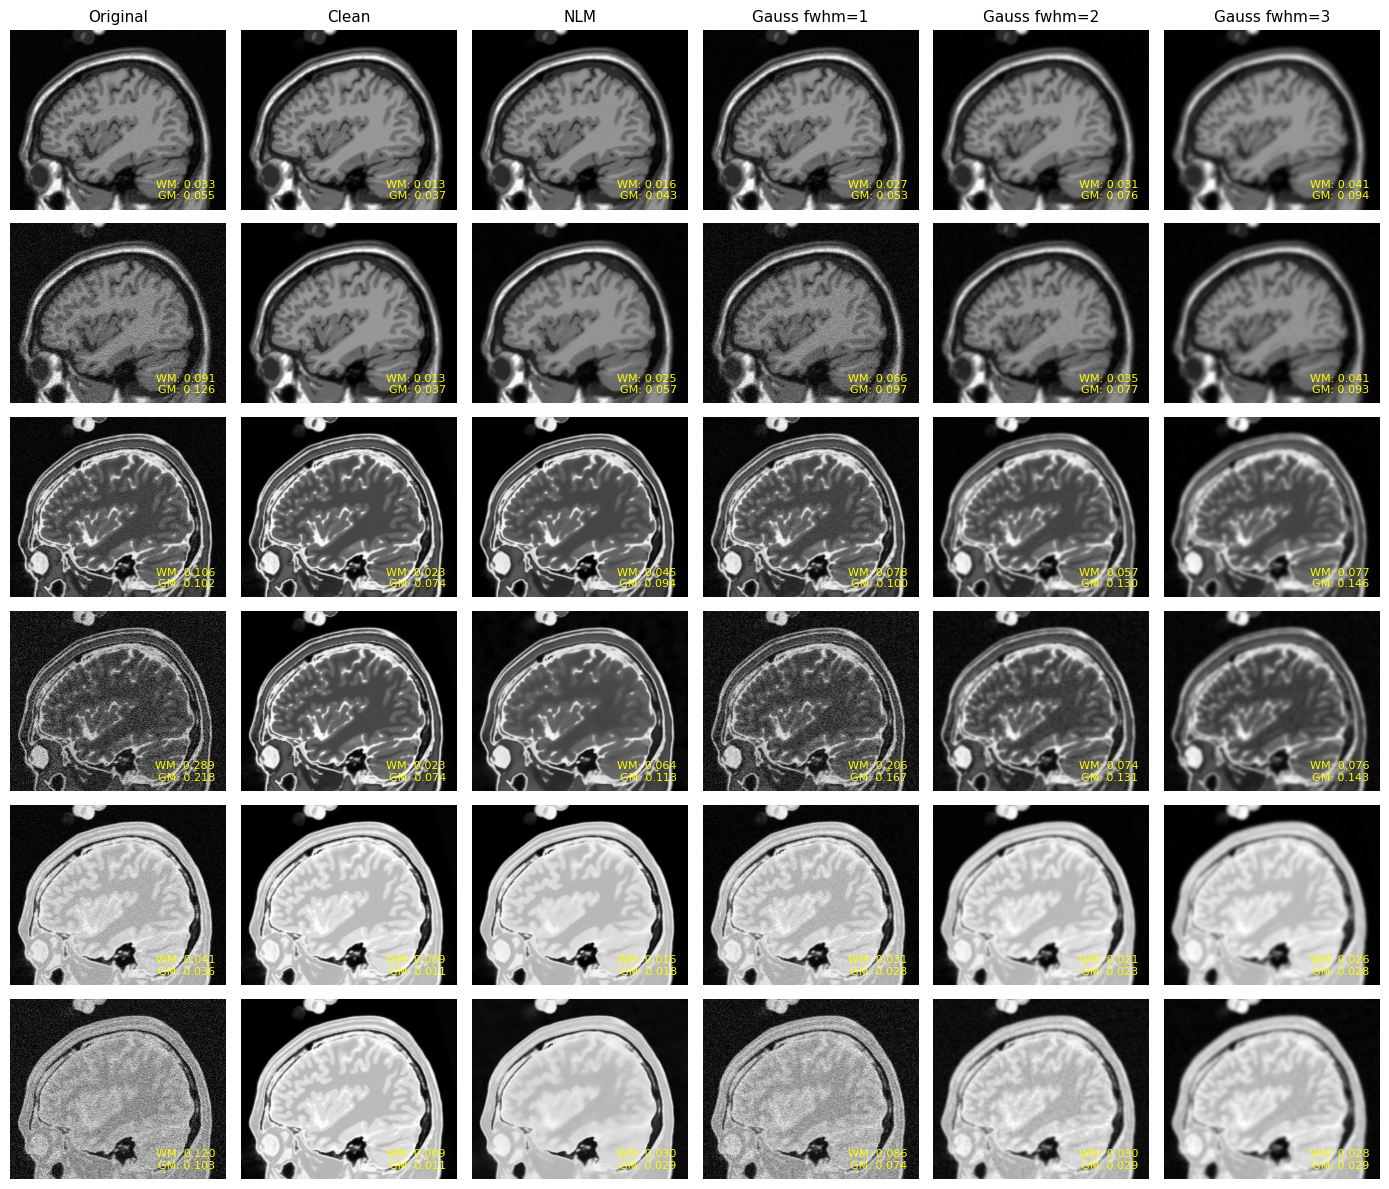

In [152]:
import matplotlib.pyplot as plt

slice_idx = 50   # Choose one slice index to display consistently
fig, axes = plt.subplots(len(modalities)*len(noise_levels), len(methods), figsize=(14, 12))

for i, modality in enumerate(modalities):
    for j, noise in enumerate(noise_levels):
        row_idx = i*len(noise_levels) + j
        for k, method in enumerate(methods):
            ax = axes[row_idx, k]

            entry = results.get((modality, noise, method))
            if entry is not None:
                img = entry["image"]
                # pick a slice (assuming 3D volume: x,y,z)
                slice_img = np.rot90(img.get_fdata()[:, :, slice_idx], k=1)

                ax.imshow(slice_img.T, cmap="gray", origin="lower")
                ax.axis("off")

                wm_cov = entry["cov_wm"]
                gm_cov = entry["cov_gm"]

                # overlay text in bottom-right corner
                ax.text(0.95, 0.05,
                        f"WM: {wm_cov:.3f}\nGM: {gm_cov:.3f}",
                        color="yellow", fontsize=8,
                        ha="right", va="bottom",
                        transform=ax.transAxes)

            # Add row labels on the leftmost column
            if k == 0:
                ax.set_ylabel(f"{modality} @ {noise}", fontsize=10, rotation=90)

# Column headers
for k, method in enumerate(methods):
    axes[0, k].set_title(method, fontsize=11)

plt.tight_layout()
plt.show()

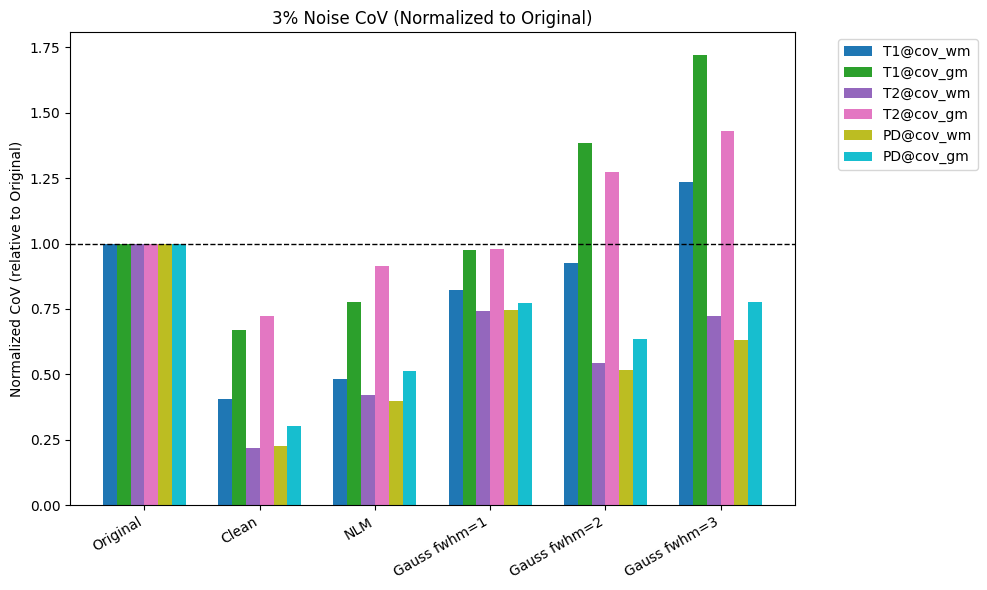

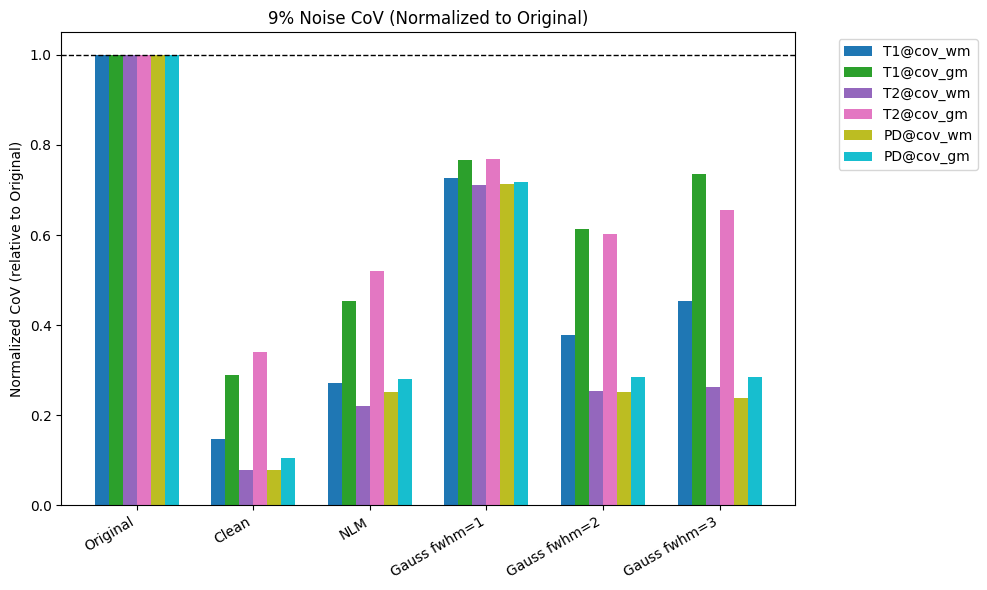

In [168]:
import matplotlib.pyplot as plt
import numpy as np

rows = [
    ("T1", "cov_wm"),
    ("T1", "cov_gm"),
    ("T2", "cov_wm"),
    ("T2", "cov_gm"),
    ("PD", "cov_wm"),
    ("PD", "cov_gm")
]

colors = plt.cm.tab10(np.linspace(0, 1, len(rows)))

def plot_cov(noise, title):
    x = np.arange(len(methods))
    bar_width = 0.12
    fig, ax = plt.subplots(figsize=(10, 6))

    for i, (modality, metric_key) in enumerate(rows):
        # Get the baseline "Original" CoV
        baseline = results[(modality, noise, "Original")][metric_key]

        # Compute normalized values
        values = []
        for method in methods:
            entry = results.get((modality, noise, method))
            if entry is not None:
                values.append(entry[metric_key] / baseline)
            else:
                values.append(np.nan)

        # Offset the bars so they group nicely
        offset = (i - len(rows)/2) * bar_width + bar_width/2
        ax.bar(x + offset, values, bar_width,
               label=f"{modality}@{metric_key}", color=colors[i])

    ax.set_xticks(x)
    ax.set_xticklabels(methods, rotation=30, ha="right")
    ax.set_ylabel("Normalized CoV (relative to Original)")
    ax.set_title(title)
    ax.axhline(1.0, color="black", linestyle="--", linewidth=1)  # baseline line
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# --- Plot WM ---
plot_cov('3%', "3% Noise CoV (Normalized to Original)")

# --- Plot GM ---
plot_cov('9%', "9% Noise CoV (Normalized to Original)")
